## Backscatter (Sigma0)

### Backscattered Radar Intensity

A single radar image is usually displayed as a grey scale image. The intensity of each pixel represents the proportion of microwave backscattered from that area on the ground which depends on a variety of factors: types, sizes, shapes and orientations of the scatterers in the target area; moisture content of the target area; frequency and polarisation of the radar pulses; as well as the incident angles of the radar beam. 

The pixel intensity values are often converted to a physical quantity called the backscattering coefficient or normalised radar cross-section measured in decibel (dB) units with values ranging from +5 dB for very bright objects to -40 dB for very dark surfaces.



In [24]:
import lxml.etree as etree
import subprocess
import tempfile
import time
import psutil
from snappy import jpy
from snappy import ProductIO
from snappy import GPF
from snappy import HashMap
import os

%matplotlib inline
import matplotlib.pyplot as plt
import gdal
import numpy as np
from shapely.wkt import loads
from shapely.geometry import Point
import osr
import ogr
from shapely import geometry
import sys

from graphviz import Digraph

sys.path.append(os.getcwd())
import ellip_snap_helpers

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Backscatter processing workflow

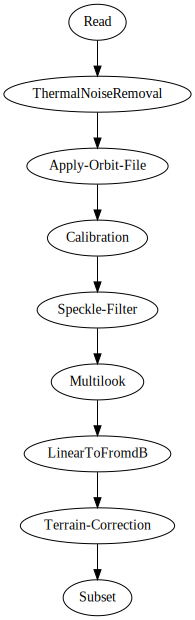

In [25]:
dot = Digraph()
dot.node('A', 'Read')
dot.node('B', 'ThermalNoiseRemoval')
dot.node('C', 'Apply-Orbit-File')
dot.node('D', 'Calibration')
dot.node('E', 'Speckle-Filter')
dot.node('F', 'Multilook')
dot.node('G', 'LinearToFromdB')
dot.node('H', 'Terrain-Correction')
dot.node('I', 'Subset')


dot.edges(['AB', 'BC', 'CD', 'DE', 'EF', 'FG', 'GH', 'HI'])

dot

##### Apply-Orbit-File

The orbit state vectors provided in the metadata of a SAR product are generally not accurate and can be refined with the precise orbit files which are available days-to-weeks after the generation of the product. 

The orbit file provides accurate satellite position and velocity information. Based on this information, the orbit state vectors in the abstract metadata of the product are updated.

The Precise Orbit Determination (POD) service for SENTINEL-1 provides Restituted orbit files and Precise Orbit Ephemerides (POE) orbit files. POE files cover approximately 28 hours and contain orbit state vectors at fixed time steps of 10 seconds intervals. Files are generated one file per day and are delivered within 20 days after data acquisition. 

In [2]:
mygraph = ellip_snap_helpers.GraphProcessor()

In [3]:
operator = 'Read'

node_id = 'Read'

source_node_id = ''

parameters = ellip_snap_helpers.get_operator_default_parameters(operator)

parameters['file'] = '/data2/S1B_EW_GRDM_1SDH_20180822T114138_20180822T114238_012375_016D07_E770.zip' 
    
mygraph.add_node(node_id, operator, parameters, source_node_id)

### Thermal Noise Removal

In [4]:
operator = 'ThermalNoiseRemoval'

node_id = 'ThermalNoiseRemoval' 

source_node_id = 'Read'

parameters = ellip_snap_helpers.get_operator_default_parameters(operator)

mygraph.add_node(node_id, operator, parameters, source_node_id)

In [5]:
operator = 'Apply-Orbit-File'

node_id = 'Apply-Orbit-File' 

source_node_id = 'ThermalNoiseRemoval'

parameters = ellip_snap_helpers.get_operator_default_parameters(operator)

mygraph.add_node(node_id, operator, parameters, source_node_id)

In [6]:
operator = 'Calibration'

node_id = 'Calibration' 

source_node_id = 'Apply-Orbit-File'

parameters = ellip_snap_helpers.get_operator_default_parameters(operator)

mygraph.add_node(node_id, operator, parameters, source_node_id)

In [8]:
operator = 'Speckle-Filter'

node_id = 'Speckle-Filter' 

source_node_id = 'Calibration'

parameters = ellip_snap_helpers.get_operator_default_parameters(operator)

mygraph.add_node(node_id, operator, parameters, source_node_id)


In [9]:
operator = 'Multilook'

node_id = 'Multilook' 

source_node_id = 'Speckle-Filter'

parameters = ellip_snap_helpers.get_operator_default_parameters(operator)

mygraph.add_node(node_id, operator, parameters, source_node_id)

In [10]:
operator = 'LinearToFromdB'

node_id = 'LinearToFromdB' 

source_node_id = 'Multilook'

parameters = ellip_snap_helpers.get_operator_default_parameters(operator)

mygraph.add_node(node_id, operator, parameters, source_node_id)

### Terrain correction

In [11]:
operator = 'Terrain-Correction'

map_proj = """PROJCS["WGS 84 / Arctic Polar Stereographic", 
  GEOGCS["WGS 84", 
    DATUM["World Geodetic System 1984", 
      SPHEROID["WGS 84", 6378137.0, 298.257223563, AUTHORITY["EPSG","7030"]], 
      AUTHORITY["EPSG","6326"]], 
    PRIMEM["Greenwich", 0.0, AUTHORITY["EPSG","8901"]], 
    UNIT["degree", 0.017453292519943295], 
    AXIS["Geodetic longitude", EAST], 
    AXIS["Geodetic latitude", NORTH], 
    AUTHORITY["EPSG","4326"]], 
  PROJECTION["Polar Stereographic (variant B)", AUTHORITY["EPSG","9829"]], 
  PARAMETER["central_meridian", 0.0], 
  PARAMETER["Standard_Parallel_1", 71.0], 
  PARAMETER["false_easting", 0.0], 
  PARAMETER["false_northing", 0.0], 
  UNIT["m", 1.0], 
  AXIS["Easting", "South along 90 deg East"], 
  AXIS["Northing", "South along 180 deg"], 
  AUTHORITY["EPSG","3995"]]"""

node_id = 'Terrain-Correction' 

source_node_id = 'LinearToFromdB'

parameters = ellip_snap_helpers.get_operator_default_parameters(operator)

parameters['demName'] = 'ACE30'  
parameters['saveDEM'] = 'true'
parameters['mapProjection'] = map_proj
parameters['nodataValueAtSea'] = 'false'   
                

mygraph.add_node(node_id, operator, parameters, source_node_id)



### Subset 

In [12]:
def extend_aoi(center_x, center_y, extent):
    
    center_polar = loads(convert_coords(4326, 3995, Point(center_x, center_y).wkt))
    
    ll = convert_coords(3995, 4326, Point(center_polar.x - extent,  center_polar.y - extent).wkt)
    lr = convert_coords(3995, 4326, Point(center_polar.x + extent,  center_polar.y - extent).wkt)
    ur = convert_coords(3995, 4326, Point(center_polar.x + extent,  center_polar.y + extent).wkt)
    ul = convert_coords(3995, 4326, Point(center_polar.x - extent,  center_polar.y + extent).wkt)


    pointList = [loads(ll),
             loads(lr), 
             loads(ur), 
             loads(ul), 
             loads(ll)]

    extended_aoi = geometry.Polygon([[p.x, p.y] for p in pointList]).wkt
    
    return extended_aoi

In [13]:
def convert_coords(source_epsg, target_epsg, geom):

    source = osr.SpatialReference()
    source.ImportFromEPSG(source_epsg)

    target = osr.SpatialReference()
    target.ImportFromEPSG(target_epsg)

    transform = osr.CoordinateTransformation(source, target)

    point = ogr.CreateGeometryFromWkt(geom)
    point.Transform(transform)

    return point.ExportToWkt()

In [14]:
poi = loads('POINT (-35.3 83.90000000000001)')

In [15]:
extended_aoi = extend_aoi(poi.x, poi.y, 50000)

extended_aoi

'POLYGON ((-36.2310862509672 83.2595511507302, -29.4071545191827 83.75772664159339, -34.1503429540384 84.5388284015394, -41.4067813117152 83.9752312745992, -36.2310862509672 83.2595511507302))'

In [16]:
operator = 'Subset'

node_id = 'Subset' 

source_node_id = 'Terrain-Correction'

parameters = ellip_snap_helpers.get_operator_default_parameters(operator)

parameters['geoRegion'] = extended_aoi 

mygraph.add_node(node_id, operator, parameters, source_node_id)


### Write

In [17]:
operator = 'Write'

node_id = 'Write' 

source_node_id = 'Subset'

parameters = ellip_snap_helpers.get_operator_default_parameters(operator)

parameters['file'] = 'sigma0'
parameters['formatName'] = 'GeoTIFF-BigTiff'

mygraph.add_node(node_id, operator, parameters, source_node_id)


In [18]:
mygraph.view_graph()

<graph>
  <version>1.0</version>
  <node id="Read">
    <operator>Read</operator>
    <sources/>
    <parameters class="com.bc.ceres.binding.dom.XppDomElement">
      <formatName/>
      <file>/data2/S1B_EW_GRDM_1SDH_20180822T114138_20180822T114238_012375_016D07_E770.zip</file>
    </parameters>
  </node>
  <node id="ThermalNoiseRemoval">
    <operator>ThermalNoiseRemoval</operator>
    <sources>
      <sourceProduct refid="Read"/>
    </sources>
    <parameters class="com.bc.ceres.binding.dom.XppDomElement">
      <reIntroduceThermalNoise>false</reIntroduceThermalNoise>
      <selectedPolarisations/>
      <removeThermalNoise>true</removeThermalNoise>
    </parameters>
  </node>
  <node id="Apply-Orbit-File">
    <operator>Apply-Orbit-File</operator>
    <sources>
      <sourceProduct refid="ThermalNoiseRemoval"/>
    </sources>
    <parameters class="com.bc.ceres.binding.dom.XppDomElement">
      <polyDegree>3</polyDegree>
      <orbitType>Sentinel Precise (Auto Download)</orbitType>

In [19]:
mygraph.run()

Processing the graph
27190
Executing processing graph
....11%....22%....33%....45%....56%....67%....78%....90% done.
INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
SEVERE: org.esa.s2tbx.dataio.gdal.activator.GDALDistributionInstaller: The environment variable LD_LIBRARY_PATH is not set. It must contain the current folder '.'.
INFO: org.hsqldb.persist.Logger: dataFileCache open start



Add plot for all bands:

- Sigma0_HH_db
- Sigma0_HV_db
- elevation

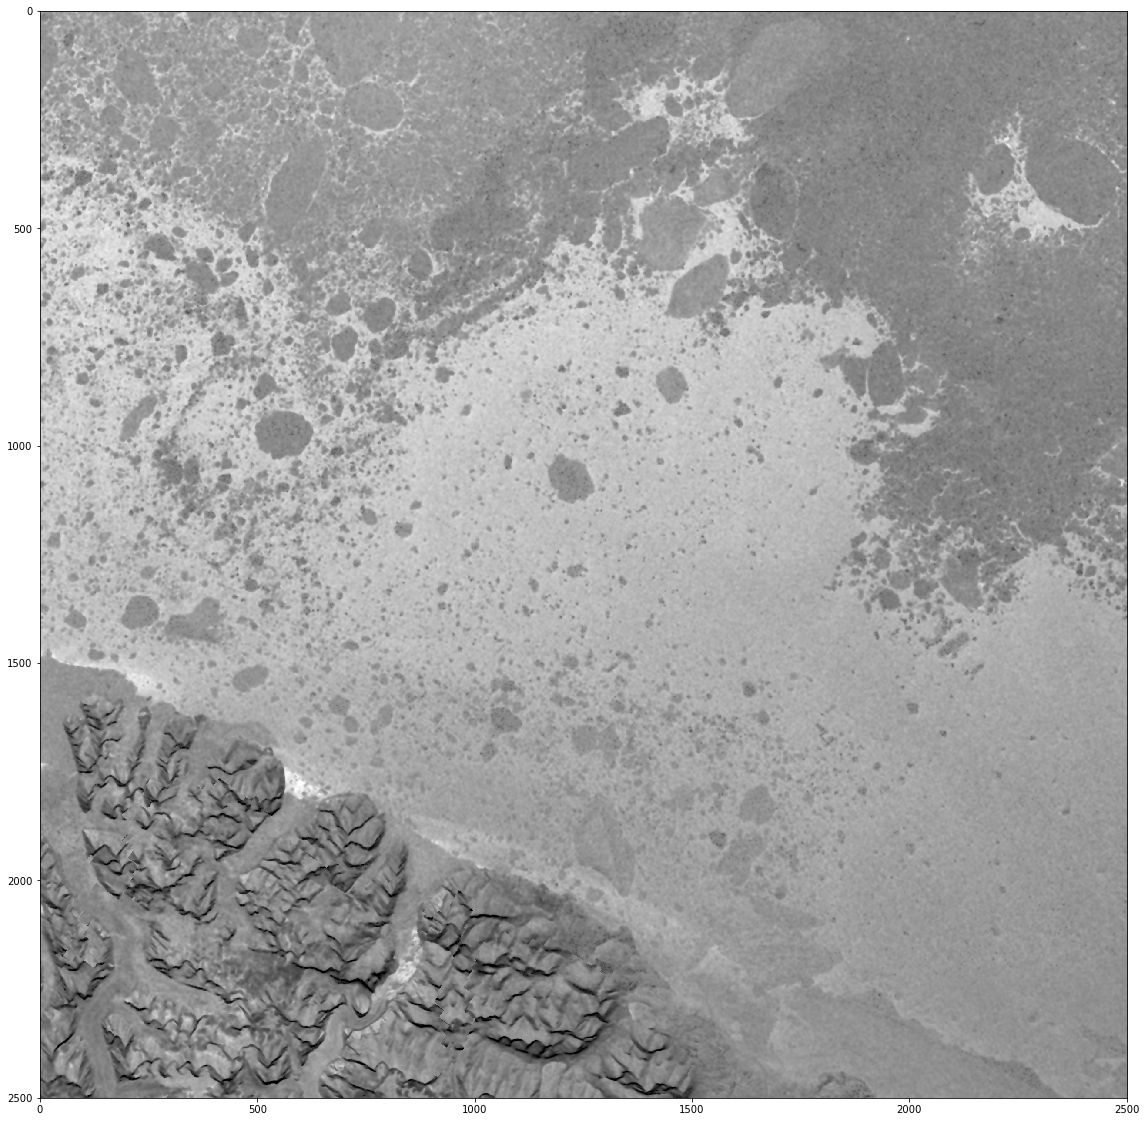

In [21]:
fig = plt.figure(figsize=(20,20))

ds = gdal.Open('sigma0.tif')
band = ds.GetRasterBand(1)

imgplot = plt.imshow(band.ReadAsArray().astype(np.float),
                         cmap=plt.cm.binary, 
                         vmin=-26, 
                         vmax=6)

plt.show()